### Here we generate a spatially-varying `CoaddPsf` as the ALDecorrelation kernel and attempt to convolve the diffim with that.

It doesn't work -- `Psfs` in general and `CoaddPsfs` in particular cannot be used as a convolution kernel.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(varFlux2=np.repeat(2000, 20), 
                         #varFlux2=np.repeat(620*np.sqrt(2), 20),
                         n_sources=600, verbose=True, sourceFluxRange=(2000., 120000.), 
                         psf_yvary_factor=0.5, psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.492813481453 0.493450410102
Variable source: 11 481.504254729 446.769330925 0 2000
Variable source: 6 60.2485291279 35.3191743182 0 2000
Variable source: 19 441.050733817 436.806559587 0 2000
Variable source: 20 446.291646029 86.4683838602 0 2000
Variable source: 1 66.5809759253 424.38486369 0 2000
Variable source: 12 466.843050607 342.354052063 0 2000
Variable source: 17 45.6530981449 331.260325215 0 2000
Variable source: 10 302.643969883 44.7418294743 0 2000
Variable source: 0 368.142255845 436.045411845 0 2000
Variable source: 13 146.056622889 434.017042329 0 2000
Variable source: 5 396.07140698 121.296576813 0 2000
Variable source: 21 245.245586804 439.913841214 0 2000
Variable source: 24 129.950748293 390.033308509 0 2000
Variable source: 4 431.666157472 255.180259503 0 2000
Variable source: 8 277.951989376 82.2791446766 0 2000
Variable source: 22 233.327308185 

In [3]:
import lsst.afw.geom as afwGeom

exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

exposure.setPsf(testObj.variablePsf.getCoaddPsf(exposure))
exposure.getPsf().computeKernelImage(afwGeom.Point2D(28., 66.)).getDimensions()

Extent2I(27, 25)

A&L(dec): stats(mean=0.11608639, stdev=24.692617, min=-162.86592, max=252.57611)
Zogy: stats(mean=0.071210623, stdev=24.9333, min=-766.08795, max=920.04163)
A&L(dec) - Zogy: stats(mean=0.008017364, stdev=2.7184396, min=-509.36853, max=760.64014)
A&L(dec) - A&L: stats(mean=-0.03347978, stdev=6.8337188, min=-45.460281, max=70.804291)
Scorr: stats(mean=3.9852544e-06, stdev=0.00026903153, min=-0.014586432, max=0.013801034)
Scorr_var: stats(mean=0.00025189554, stdev=1.4065441e-06, min=0.0002467375, max=0.00095368025)


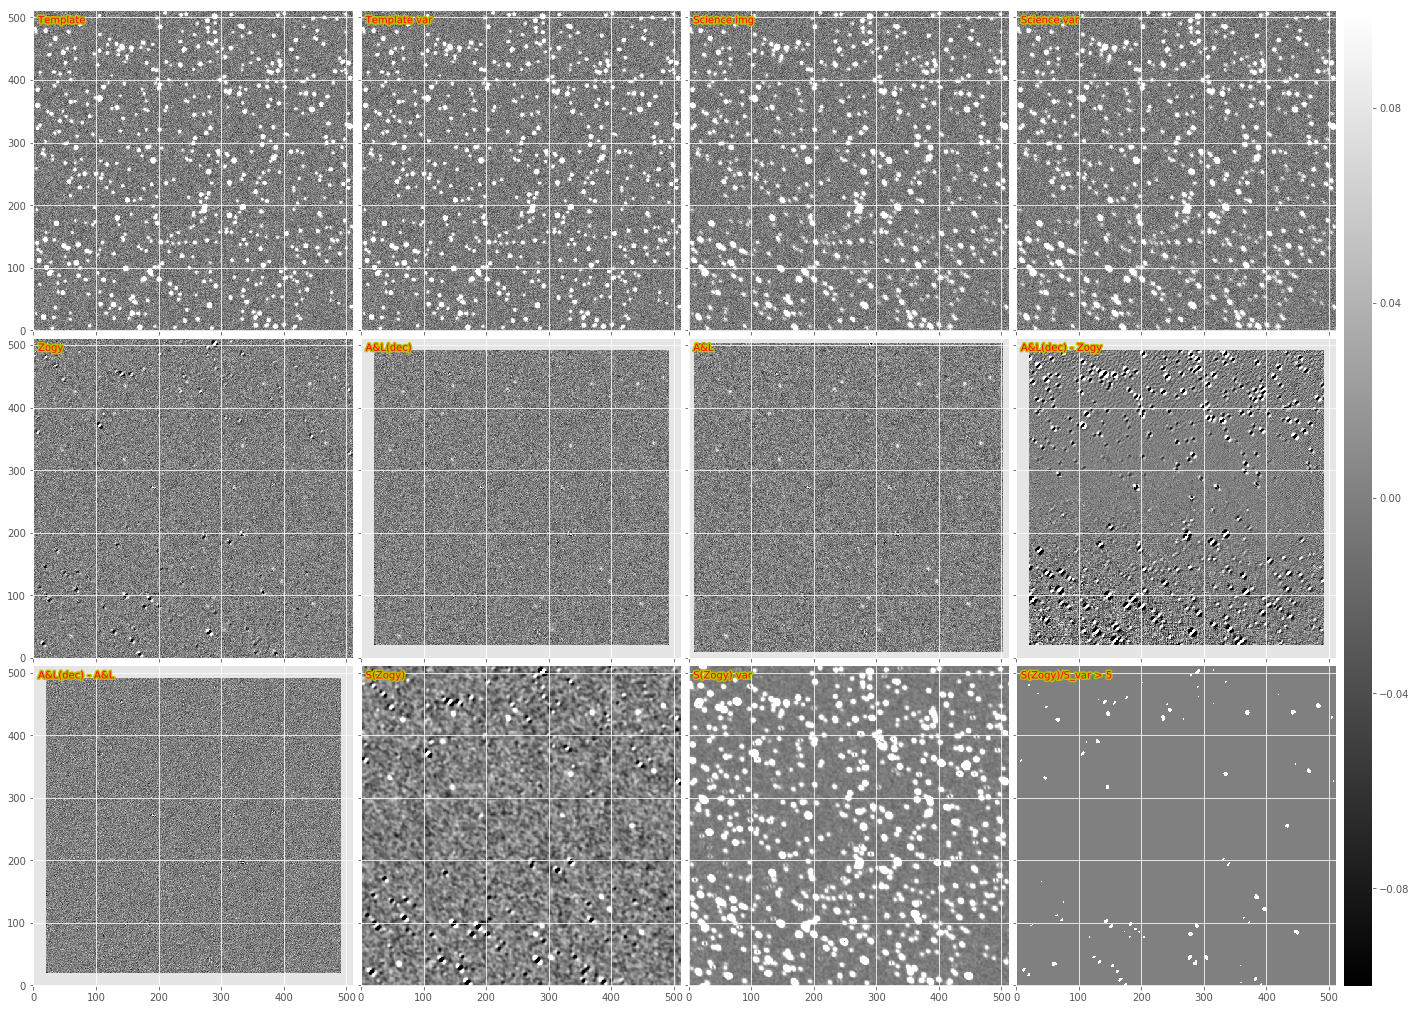

In [4]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=6, include_Szogy=True);

In [5]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

In [6]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()

In [7]:
#import testPsfexPsfEDITED as tpp
#reload(tpp)

exposure2 = testObj.im2.asAfwExposure()
#res = dit.tasks.doMeasurePsf(exposure2) #, psfMeasureConfig=config)
#psf = res.psf
obj = dit.tasks.PsfMeasurement(exposure2)
obj.run()
psf = obj.exposure.getPsf()
exposure2.setPsf(psf)

template2 = testObj.im1.asAfwExposure()
#res = dit.tasks.doMeasurePsf(template2) #, psfMeasureConfig=config)
#psf = res.psf
obj = dit.tasks.PsfMeasurement(template2)
obj.run()
psf = obj.exposure.getPsf()
template2.setPsf(psf)

539
538


In [8]:
ALres = dit.tasks.doAlInStack(template2, exposure2, doWarping=False, doDecorr=True, doPreConv=False,
            spatialBackgroundOrder=0, spatialKernelOrder=2)

In [9]:
config = dit.DecorrelateALKernelMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
#task = ipDiffim.ImageMapReduceTask(config=config)
print config

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [10]:
res = task.run(ALres.subtractedExposure, template=template2, science=exposure2,
                  alTaskResult=ALres, forceEvenSized=True)
newExpC = res.exposure

diffimTests/imageMapReduce.py:281: RuntimeWarning: invalid value encountered in true_divide
  newMI.getImage().getArray()[:, :] /= wts
diffimTests/imageMapReduce.py:282: RuntimeWarning: invalid value encountered in true_divide
  newMI.getVariance().getArray()[:, :] /= wts


In [11]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExpC
testObj2.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 2, 'FP': 0, 'TP': 18},
 'SZogy': {'FN': 2, 'FP': 29, 'TP': 18},
 'Zogy': {'FN': 1, 'FP': 34, 'TP': 19}}

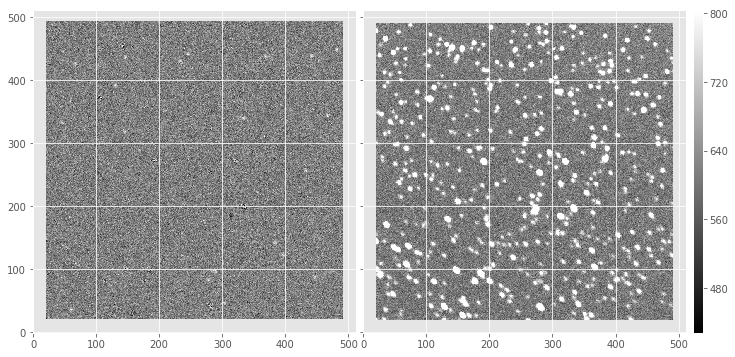

In [12]:
dit.plotImageGrid((newExpC, newExpC.getMaskedImage().getVariance()), imScale=6)

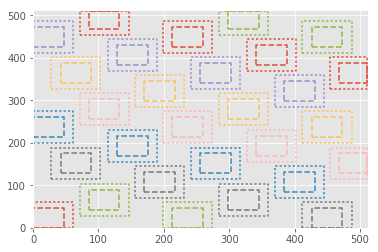

In [13]:
task.plotBoxes(newExpC.getBBox(), 5)

Finally, let's compare it to spatially-varying ZOGY!

NOTE that the `gridStep/gridSize` combo doesn't seem to correctly fully cover the entire image in all cases! In this case (the default), it does, but if I uncomment the 'gridStep' setting line below, it doesn't.

In [14]:
config = dit.ZogyMapReduceConfig()
#config.gridStepX = config.gridStepY = 9
#config.gridSizeX = config.gridSizeY = 10
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [15]:
newExpZ = task.run(exposure2, template=template2, inImageSpace=False,
                       Scorr=False, forceEvenSized=True).exposure
newExpZ_Scorr = task.run(exposure2, template=template2, inImageSpace=False,
                       Scorr=True, forceEvenSized=True).exposure

In [16]:
testObj3 = testObj.clone()
testObj3.ALres.decorrelatedDiffim = newExpC
testObj3.D_Zogy = newExpZ  #dit.Exposure(ga(newExpZ), testObj.D_Zogy.psf, gv(newExpZ))
testObj3.S_Zogy = newExpZ_Scorr  #dit.Exposure(ga(newExpZ_Scorr), dit.psf.afwPsfToArray(newExpZ_Scorr.getPsf()), gv(newExpZ_Scorr))
testObj3.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 0, 'FP': 0, 'TP': 20},
 'ALstack_decorr': {'FN': 2, 'FP': 0, 'TP': 18},
 'SZogy': {'FN': 0, 'FP': 0, 'TP': 20},
 'Zogy': {'FN': 0, 'FP': 0, 'TP': 20}}

A&L(dec): stats(mean=0.11799736, stdev=24.61161, min=-164.08002, max=256.78632)
Zogy: stats(mean=0.062848262, stdev=24.839464, min=-343.39426, max=297.7673)
A&L(dec) - Zogy: stats(mean=0.039931569, stdev=28.820517, min=-258.33334, max=237.18842)
A&L(dec) - A&L: stats(mean=-0.032931708, stdev=6.7740631, min=-47.245255, max=70.115891)
Scorr: stats(mean=1.4689194e-06, stdev=0.00025058389, min=-0.0026853129, max=0.0045413231)
Scorr_var: stats(mean=0.00024780285, stdev=1.2374662e-05, min=0.00022234186, max=0.00091328984)


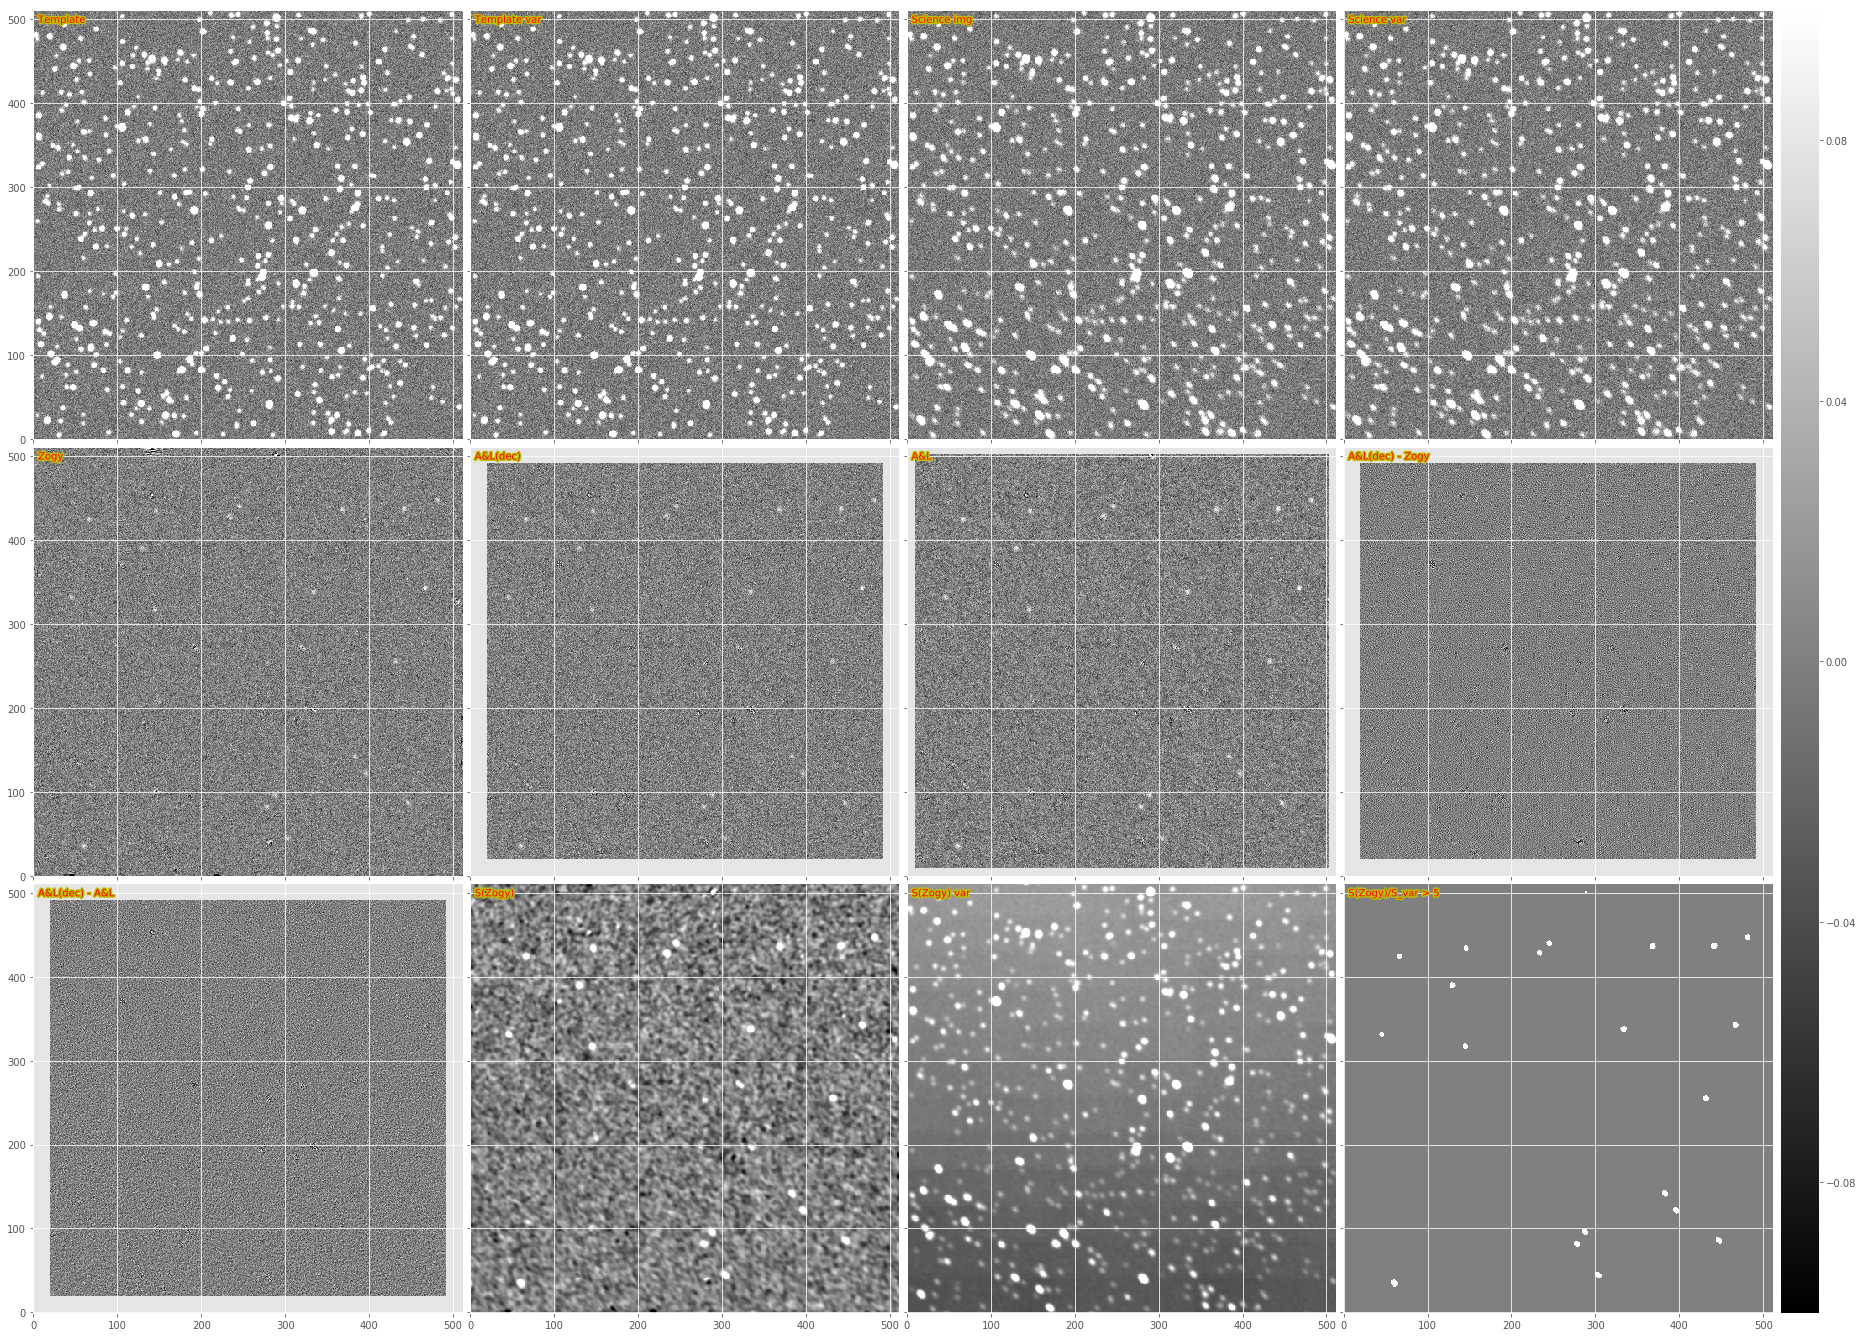

In [17]:
testObj3.doPlot(imScale=8, include_Szogy=True); #, centroidCoord=[424,66]);

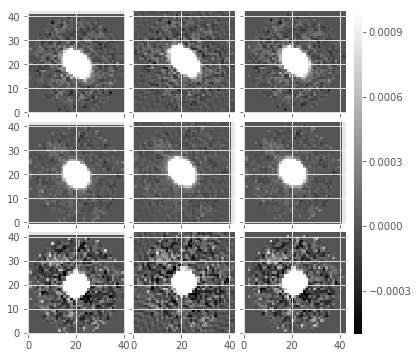

In [18]:
def gp(exp, coord):
    return exp.getPsf().computeImage(afwGeom.Point2D(coord[0], coord[1])).getArray()
    
dit.plotImageGrid((gp(exposure2, [80,80]), gp(newExpC, [80,80]), gp(newExpZ, [80,80]),
                   gp(exposure2, [255,255]), gp(newExpC, [255,255]), gp(newExpZ, [255,255]),
                   gp(exposure2, [480,480]), gp(newExpC, [480,480]), gp(newExpZ, [480,480]),), 
                  clim=(-0.0005, 0.001), nrows_ncols=(3, 3))

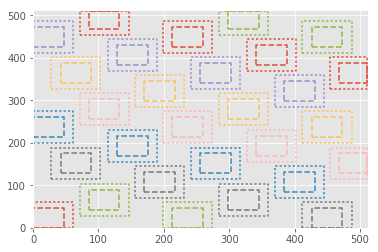

In [19]:
task.plotBoxes(exposure2.getBBox(), skip=5)

In [20]:
print task.mapperSubtask._DefaultName
print task.reducerSubtask._DefaultName

diffimTests_ZogyMapperSubtask
ip_diffim_ImageReducerSubtask


Try new method of just creating a spatially-varying CoaddPsf and then use that...

In [21]:
config = dit.SpatialDecorrelateALKernelMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'coaddPsf'  # should already be default
task = dit.ImageMapReduceTask(config=config)
print config

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reduceOperation': 'coaddPsf', 'reducerSubtask': {'reduceOperation': 'coaddPsf'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [22]:
def pp(psf, coord):
    return psf.computeImage(afwGeom.Point2D(coord[0], coord[1])).getArray()

<class 'lsst.meas.algorithms.coaddPsf.CoaddPsf'>


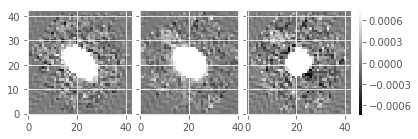

In [23]:
res = task.run(ALres.subtractedExposure, template=template2, science=exposure2,
                  alTaskResult=ALres, forceEvenSized=True, returnDiffimPsf=True)

print type(res.result)
psf = res.result
dit.plotImageGrid((pp(psf, [80,80]), pp(psf, [255,255]), pp(psf, [480,480])))

<class 'lsst.meas.algorithms.coaddPsf.CoaddPsf'>


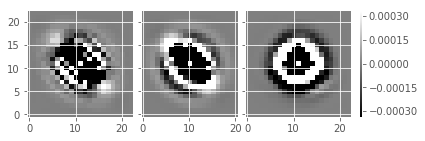

In [24]:
res = task.run(ALres.subtractedExposure, template=template2, science=exposure2,
                  alTaskResult=ALres, forceEvenSized=True)

print type(res.result)
psf = res.result
dit.plotImageGrid((pp(psf, [80,80]), pp(psf, [255,255]), pp(psf, [480,480])))

In [25]:
outExp = exposure2.clone()  # Do this to keep WCS, PSF, masks, etc.2
print type(psf), type(outExp), type(exposure2), type(outExp.getMaskedImage()), type(exposure2.getMaskedImage())
convCntrl = afwMath.ConvolutionControl(False, True, 0)
afwMath.convolve(outExp.getMaskedImage(), exposure2.getMaskedImage(), psf, convCntrl)

<class 'lsst.meas.algorithms.coaddPsf.CoaddPsf'> <class 'lsst.afw.image.exposure.exposure.ExposureF'> <class 'lsst.afw.image.exposure.exposure.ExposureF'> <class 'lsst.afw.image.maskedImage.maskedImage.MaskedImageF'> <class 'lsst.afw.image.maskedImage.maskedImage.MaskedImageF'>


TypeError: convolve(): incompatible function arguments. The following argument types are supported:
    1. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3068>) -> None
    2. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    3. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee30a0>) -> None
    4. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    5. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee30d8>) -> None
    6. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    7. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3110>) -> None
    8. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    9. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3148>) -> None
    10. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    11. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3180>) -> None
    12. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageD, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    13. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee31b8>) -> None
    14. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    15. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee31f0>) -> None
    16. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    17. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3228>) -> None
    18. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    19. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3260>) -> None
    20. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    21. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3298>) -> None
    22. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    23. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee32d0>) -> None
    24. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    25. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3308>) -> None
    26. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    27. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3340>) -> None
    28. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    29. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3378>) -> None
    30. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    31. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee33b0>) -> None
    32. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    33. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee33e8>) -> None
    34. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    35. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3420>) -> None
    36. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    37. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3458>) -> None
    38. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    39. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3490>) -> None
    40. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    41. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee34c8>) -> None
    42. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    43. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3500>) -> None
    44. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    45. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3538>) -> None
    46. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    47. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3570>) -> None
    48. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    49. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee35a8>) -> None
    50. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    51. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee35e0>) -> None
    52. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    53. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3618>) -> None
    54. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    55. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3650>) -> None
    56. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    57. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3688>) -> None
    58. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    59. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee36c0>) -> None
    60. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    61. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee36f8>) -> None
    62. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    63. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3730>) -> None
    64. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    65. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3768>) -> None
    66. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    67. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee37a0>) -> None
    68. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    69. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee37d8>) -> None
    70. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    71. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3810>) -> None
    72. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    73. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3848>) -> None
    74. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    75. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3880>) -> None
    76. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    77. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee38b8>) -> None
    78. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    79. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee38f0>) -> None
    80. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    81. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3928>) -> None
    82. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    83. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3960>) -> None
    84. (convolvedImage: lsst.afw.image.image.image.ImageD, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    85. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3998>) -> None
    86. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    87. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee39d0>) -> None
    88. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    89. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3a08>) -> None
    90. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    91. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3a40>) -> None
    92. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    93. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3a78>) -> None
    94. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    95. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ab0>) -> None
    96. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageD, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    97. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ae8>) -> None
    98. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    99. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3b20>) -> None
    100. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    101. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3b58>) -> None
    102. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    103. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3b90>) -> None
    104. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    105. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3bc8>) -> None
    106. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    107. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3c00>) -> None
    108. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageF, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    109. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3c38>) -> None
    110. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    111. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3c70>) -> None
    112. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    113. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ca8>) -> None
    114. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    115. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ce0>) -> None
    116. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    117. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3d18>) -> None
    118. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    119. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3d50>) -> None
    120. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    121. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3d88>) -> None
    122. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    123. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3dc0>) -> None
    124. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    125. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3df8>) -> None
    126. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    127. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3e30>) -> None
    128. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    129. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3e68>) -> None
    130. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    131. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ea0>) -> None
    132. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    133. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3ed8>) -> None
    134. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    135. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3f10>) -> None
    136. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    137. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3f48>) -> None
    138. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    139. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3f80>) -> None
    140. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    141. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee3fb8>) -> None
    142. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    143. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4030>) -> None
    144. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    145. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4068>) -> None
    146. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    147. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee40a0>) -> None
    148. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    149. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee40d8>) -> None
    150. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    151. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4110>) -> None
    152. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    153. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4148>) -> None
    154. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    155. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4180>) -> None
    156. (convolvedImage: lsst.afw.image.image.image.ImageF, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    157. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee41b8>) -> None
    158. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    159. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee41f0>) -> None
    160. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    161. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4228>) -> None
    162. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    163. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4260>) -> None
    164. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    165. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4298>) -> None
    166. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    167. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee42d0>) -> None
    168. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    169. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4308>) -> None
    170. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    171. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4340>) -> None
    172. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    173. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4378>) -> None
    174. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    175. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee43b0>) -> None
    176. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    177. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee43e8>) -> None
    178. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    179. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4420>) -> None
    180. (convolvedImage: lsst.afw.image.image.image.ImageI, inImage: lsst.afw.image.image.image.ImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    181. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4458>) -> None
    182. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    183. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4490>) -> None
    184. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    185. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee44c8>) -> None
    186. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    187. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4500>) -> None
    188. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    189. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4538>) -> None
    190. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    191. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4570>) -> None
    192. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageI, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    193. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee45a8>) -> None
    194. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    195. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee45e0>) -> None
    196. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    197. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4618>) -> None
    198. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    199. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4650>) -> None
    200. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    201. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4688>) -> None
    202. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    203. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee46c0>) -> None
    204. (convolvedImage: lsst.afw.image.image.image.ImageU, inImage: lsst.afw.image.image.image.ImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    205. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee46f8>) -> None
    206. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::AnalyticKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    207. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4730>) -> None
    208. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::DeltaFunctionKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    209. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4768>) -> None
    210. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::FixedKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    211. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee47a0>) -> None
    212. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::LinearCombinationKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    213. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee47d8>) -> None
    214. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::SeparableKernel, doNormalize: bool, doCopyEdge: bool=False) -> None
    215. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, convolutionControl: lsst.afw.math._convolveImage.ConvolutionControl=<lsst.afw.math._convolveImage.ConvolutionControl object at 0x11cee4810>) -> None
    216. (convolvedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, inImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageU, kernel: lsst::afw::math::Kernel, doNormalize: bool, doCopyEdge: bool=False) -> None

Invoked with: <lsst.afw.image.maskedImage.maskedImage.MaskedImageF object at 0x1395d03e8>, <lsst.afw.image.maskedImage.maskedImage.MaskedImageF object at 0x1395d0458>, <lsst.meas.algorithms.coaddPsf.CoaddPsf object at 0x13c2576c0>, <lsst.afw.math._convolveImage.ConvolutionControl object at 0x1395d0378>